# Folded Electro-Optic Modulators on TFLN: Layout


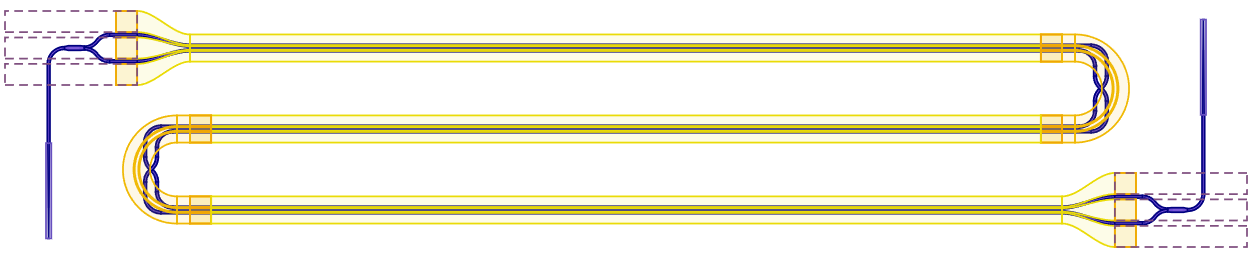


This notebook provides a step-by-step guide for generating the circuit layout of folded electro-optical modulators based on a thin-film lithium niobate (TFLN) platform. Inspired by the CMOS-compatible design demonstrated by Della Torre et al. [1](https://opg.optica.org/abstract.cfm?uri=oe-33-4-6747), the modulators achieve a compact footprint, low half-wave voltage (~0.9 V), and high-frequency operation (>40 GHz). This example spans two notebooks. In this **first part**, we focus on creating **the device layout**, while the second part is dedicated to simulation and analysis.

We first define a custom technology closely resembling that used in [1]. Then, we create the required building blocks, and finally integrate them into a complete optical and RF circuit layout.

**References**
1. Della Torre, Alberto, *et al*. "Folded electro-optical modulators operating at CMOS voltage level in a thin-film lithium niobate foundry process." *Optics Express* 2025 33 (4), 6747-6757, doi: [10.1364/OE.548003](https://doi.org/10.1364/OE.548003).


In [1]:
import luxtelligence_lnoi400_forge as lxt
import numpy as np
import photonforge as pf
import tidy3d as td
import matplotlib.pyplot as plt
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()

Starting live viewer at http://localhost:5001


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.


First, we define the geometric parameters of electrodes, electrical pads, and optical waveguide structures used in the folded electro-optical modulator layout.


In [2]:
signal_width = 13.7  # Width of the CPW signal electrode (µm)
gap_width = 4.5  # Gap width between signal and ground electrodes (µm)
ground_width = 40  # Width of the CPW ground electrode (µm)
pad_length = 500  # Length of the electrical contact pads (µm)
pad_width = 80  # Width of the electrical contact pads (µm)
pad_gap = 20  # Gap between adjacent electrical pads (µm)
via_length = 80  # Size (diameter or side length) of via connections (µm)
taper_length = 200  # Length of taper transition from pad to CPW line (µm)
bend_radius = 60  # Optical waveguide bend radius (µm)
extra_cpw_path = 108.6 # An extra path added to the RF circuit to adjust phase matching condition (µm)
length_mzi_arm = 3300 # Length of MZI arms (µm)

We then set default parameters for the `photonforge` library, specifying the simulation model as `"Tidy3D"` for both curved (`bend`) and sinusoidal (`s_bend`) waveguide elements, and defining the default bend radius.


In [3]:
pf.config.default_kwargs = {
    "bend": {"active_model": "Tidy3D"},
    "s_bend": {"active_model": "Tidy3D"},
    "radius": bend_radius,
}

These parameters define the technology stack and material dimensions for the thin-film lithium niobate electro-optical modulator

In [4]:
ln_thickness = 0.6  # Thickness of the Lithium Niobate (LN) waveguide core layer (µm)
slab_thickness = 0.2  # Thickness of the LN slab layer surrounding the core (µm)
box_thickness = 4.7  # Thickness of the buried oxide (BOX) isolation layer (µm)
tox_thickness = 2.6  # Thickness of the top oxide cladding layer (µm)
tl_thickness = 0.8  # Thickness of the first metal layer (transmission line, TL) (µm)
tl_separation = 0  # Vertical separation between TL and LN slab layers (µm)
sidewall_angle = 37  # Sidewall angle of the etched LN waveguide (degrees)
top_metal_thickness = (
    0.8  # Thickness of the top metal layer for electrical contacts (µm)
)
z_top = ln_thickness + tox_thickness

## Technology Definition

The `custom_tfln_pdk` function creates a [customizable technology](../guides/Custom_Technology.rst) definition for photonic circuit design using a thin-film Lithium Niobate (TFLN) platform, closely resembling the established [LNOI400 PDK](https://github.com/flexcompute/luxtelligence-lnoi400-forge). It includes detailed specifications for material properties, geometric layers, and cross-sectional configurations. Users can precisely control parameters such as LN core thickness, slab thickness, oxide cladding layers, metallic transmission lines, sidewall angles, and substrate inclusion.


In [5]:
_Medium = td.components.medium.MediumType


@pf.parametric_technology
def custom_tfln_pdk(
    *,
    ln_thickness: float = 0.6,
    slab_thickness: float = 0.2,
    sidewall_angle: float = 37,
    box_thickness: float = 4.7,
    tox_thickness: float = 2.6,
    tl_thickness: float = 0.8,
    tl_separation: float = 0,
    top_metal_thickness: float = 0.8,
    include_substrate: bool = True,
    include_top_opening: bool = True,
    sio2: dict[str, _Medium] = {
        "optical": td.material_library["SiO2"]["Palik_Lossless"],
        "electrical": td.Medium(permittivity=3.9, name="SiO2"),
    },
    si: dict[str, _Medium] = {
        "optical": td.material_library["cSi"]["Li1993_293K"],
        "electrical": td.Medium(permittivity=11.7, name="Si"),
    },
    ln: dict[str, _Medium] = {
        "optical": td.material_library["LiNbO3"]["Zelmon1997"](optical_axis=1),
        "electrical": td.AnisotropicMedium(
            xx=td.Medium(permittivity=44),
            yy=td.Medium(permittivity=27.9),
            zz=td.Medium(permittivity=44),
        ),
    },
    tl_metal: dict[str, _Medium] = {
        "optical": td.material_library["Au"]["JohnsonChristy1972"],
        "electrical": td.LossyMetalMedium(
            conductivity=41,
            frequency_range=[0.1e9, 100e9],
            fit_param=td.SurfaceImpedanceFitterParam(max_num_poles=16),
        ),
    },
    opening: _Medium = td.Medium(permittivity=1.0, name="Opening"),
) -> pf.Technology:
    """Create a thin-film Lithium Niobate technology based on the LNOI400 PDK.

    Args:
        ln_thickness (float): LiNbO₃ layer thickness.
        slab_thickness (float): Partially etched slab thickness in LiNbO₃.
        sidewall_angle (float): Sidewall angle (in degrees) for LiNbO₃
          etching.
        box_thickness (float): Thickness of the bottom oxide clad.
        tox_thickness (float): Thickness of the top oxide clad.
        tl_thickness (float): TL layer thickness.
        tl_separation (float): Separation between the slab LiNbO₃ and TL layers.
        top_metal_thickness (float): Top metallic layer thickness
        include_substrate (bool): Flag indicating whether or not to include
          the silicon substrate.
        include_top_opening (bool): Flag indicating whether or not to
          include the open region above the last extrusion layer.
        sio2 (Medium): Oxide and background medium.
        si (Medium): Silicon medium.
        ln (Medium): LiNbO₃ medium.
        tl_metal (Medium): TL and heater metal medium.
        opening (Medium): Medium for openings.

    Returns:
        Technology: E-Beam PDK technology definition.
    """
    # Layers
    layers = {
        "LN_RIDGE": pf.LayerSpec(
            layer=(2, 0), description="LN etch (ridge)", color="#7d57de18", pattern="//"
        ),
        "LN_SLAB": pf.LayerSpec(
            layer=(3, 0), description="LN etch (full)", color="#00008018", pattern="\\"
        ),
        "SLAB_NEGATIVE": pf.LayerSpec(
            layer=(3, 1),
            description="Slab etch negative",
            color="#6750bf18",
            pattern="\\",
        ),
        "MET_1": pf.LayerSpec(
            layer=(21, 0),
            description="Metal transmission lines",
            color="#eadb0718",
            pattern="\\",
        ),
        "MET_2": pf.LayerSpec(
            layer=(21, 1), description="Top metal layer", color="#f0b90518", pattern="."
        ),
        "VIA": pf.LayerSpec(
            layer=(21, 2), description="via", color="#f0a60518", pattern="//"
        ),
    }
    # Extrusion specifications
    bounds = pf.MaskSpec()  # Empty mask for all chip bounds
    full_ln_mask = pf.MaskSpec((2, 0))
    slab_etch_mask = pf.MaskSpec((3, 1), (3, 0), "-")
    met1_mask = pf.MaskSpec((21, 0))
    met2_mask = pf.MaskSpec((21, 1))
    via_mask = pf.MaskSpec((21, 2))

    z_tl = slab_thickness + tl_separation
    z_top = ln_thickness + tox_thickness

    extrusion_specs = [
        pf.ExtrusionSpec(bounds, ln, (0, slab_thickness), 0),
        pf.ExtrusionSpec(full_ln_mask, ln, (0, ln_thickness), sidewall_angle),
        pf.ExtrusionSpec(slab_etch_mask, sio2, (-0.1, ln_thickness), -sidewall_angle),
        pf.ExtrusionSpec(met1_mask, tl_metal, (z_tl, z_tl + tl_thickness)),
        pf.ExtrusionSpec(met2_mask, tl_metal, (z_top, z_top + top_metal_thickness)),
        pf.ExtrusionSpec(via_mask, tl_metal, (z_tl + tl_thickness, z_top)),
    ]

    if include_substrate:
        extrusion_specs.append(
            pf.ExtrusionSpec(bounds, si, (-pf.Z_INF, -box_thickness))
        )

    # The top opening extrusion must be added before 'met2_mask' to ensure correct exposure of the top metal layer (MET_2)
    if include_top_opening:
        extrusion_specs.insert(0, pf.ExtrusionSpec(bounds, opening, (z_top, pf.Z_INF)))

    rwg_port_gap = min(1.5, box_thickness)
    rwg_port_limits = (-rwg_port_gap, ln_thickness + rwg_port_gap)
    swg_port_gap = min(2.1, box_thickness)
    swg_port_limits = (-swg_port_gap, slab_thickness + swg_port_gap)

    technology = pf.Technology(
        "Custom LNOI400 PDK", "1.0", layers, extrusion_specs, {}, sio2
    )
    technology.ports = {
        "RWG800": pf.PortSpec(
            description="LN single mode ridge waveguide for C-band, TE mode",
            width=5,
            limits=rwg_port_limits,
            num_modes=1,
            target_neff=2.2,
            path_profiles=((0.8, 0, (2, 0)), (10, 0, (3, 0))),
        ),
        "RWG3000": pf.PortSpec(
            description="LN multimode mode ridge for C-band, TE mode",
            width=8,
            limits=rwg_port_limits,
            num_modes=5,
            target_neff=2.2,
            path_profiles=((3, 0, (2, 0)), (12, 0, (3, 0))),
        ),
        "SWG250": pf.PortSpec(
            description="LN strip waveguide for C-band, TE mode",
            width=10,
            limits=swg_port_limits,
            num_modes=1,
            target_neff=2.2,
            path_profiles=((0.25, 0, (3, 0)), (12, 0, (3, 1))),
        ),
        "UniCPW": pf.cpw_spec(
            (21, 0),
            13.7,
            4.5,
            250,
            added_solver_modes=0,
            target_neff=2.2,
            technology=technology,
        ),
        "UniCPW-EO": pf.cpw_spec(
            (21, 0),
            10,
            4,
            180,
            added_solver_modes=0,
            target_neff=2.2,
            technology=technology,
        ),
    }
    return technology

Now, we define the technology (`tech`) using our specified parameters and set it as the default for subsequent simulations and designs.


In [6]:
tech = custom_tfln_pdk(
    ln_thickness=ln_thickness,
    slab_thickness=slab_thickness,
    sidewall_angle=sidewall_angle,
    box_thickness=box_thickness,
    tox_thickness=tox_thickness,
    tl_thickness=tl_thickness,
    top_metal_thickness=top_metal_thickness,
    tl_separation=tl_separation,
)
pf.config.default_technology = tech

To visualize how each layer is extruded in our defined technology, we create a simple test component (`test_component`) that includes representative rectangles for each technology layer.

In [7]:
test_component = pf.Component("test")

test_component.add(
    "LN_RIDGE",
    pf.Rectangle((0, 0), (2, 10)),
    "MET_1",
    pf.Rectangle((3, 0), (5, 10)),
    "MET_2",
    pf.Rectangle((4, 0), (8, 10)),
    "VIA",
    pf.Rectangle((4, 0), (5, 10)),
    "SLAB_NEGATIVE",
    pf.Rectangle((-7, 0), (-4, 10)),
    "LN_SLAB",
    pf.Rectangle((-5, 0), (-3, 10)),
)

viewer(test_component)

The visualization illustrates the function of each mask layer clearly. For example, note the `VIA` layer, which connects the `MET_1` layer to the `MET_2` layer. It's also important to highlight that the `SLAB_NEGATIVE` mask removes the slab layer, but if it overlaps with the `LN_SLAB` mask, it has no effect. In regions without any mask layers defined, only the slab layer remains.


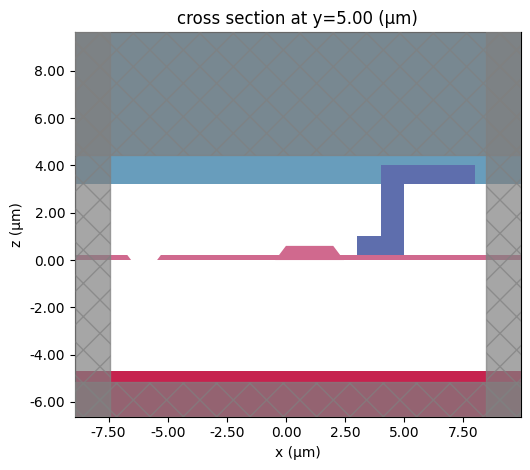

In [8]:
_ = pf.tidy3d_plot(test_component, y=5)

## Optical Components
### Edge Coupler

Next, we define essential components required for the layout design, starting with the **edge coupler**, which couples light efficiently between an optical fiber and the integrated waveguide. We utilize the `luxtelligence_lnoi400_forge` PDK to create this component through the provided function (we can use this PDK because our custom technology has layers similar to the [LNOI400 PDK](https://github.com/flexcompute/luxtelligence-lnoi400-forge)). The edge coupler is constructed by tapering the rib waveguide port down to a narrow-width slab waveguide, thereby producing a wide optical mode profile closely matching that of the optical fiber.

We added a simple `Lossless Model` to avoid computationally expensive FDTD simulations for the edge coupler. According to reference [1], fiber-to-chip coupling (and vice versa) incurs approximately 4 dB of optical loss. If desired, we can incorporate this loss explicitly into the model.


In [9]:
# Create a double linear inverse taper edge coupler targeting the "RWG800" port.
edge_coupler = lxt.component.double_linear_inverse_taper(end_port_spec="RWG800")

# Add a basic lossless two-port model for simple circuit simulations.
edge_coupler.add_model(pf.TwoPortModel(), model_name="Lossless Model")

# Display the edge coupler layout using the initialized viewer.
viewer(edge_coupler)


### Angled Waveguide Crossing

This component creates a waveguide crossing where the paths intersect at an angle. 

The process involves:
1.  Defining a `base_path` for one arm of the crossing (e.g., P0 to P3). This path consists of two 45-degree bends (`arc`) connected by diagonal segments (`segment`).
2.  The diagonal segments include tapers to increase the waveguide width (`taper_width`) in the central interaction region, reducing loss and crosstalk, before tapering back down.
3.  Dimensions are calculated based on the input lengths (`taper_length`, `cross_length`) projected onto 45-degree axes and snapped to the grid for robustness.
4.  The `base_path` is traced for each layer defined in the `port_spec` (e.g., "RWG800") to build one complete arm (`arm`).
5.  The final crossing component is assembled by placing one `arm` reference and a second reference reflected across the x-axis (`x_reflection=True`) to create the intersecting path (e.g., P2 to P1).
6.  Ports are automatically detected at the boundaries, and a `Tidy3DModel` with a field monitor is added for simulation.



In [10]:
@pf.parametric_component() # Decorator indicating this function defines a parametric PhotonForge component
def angled_crossing(
    *,
    port_spec="RWG800",    # Input/output port specification (determines waveguide cross-section)
    taper_length=3.12,    # Diagonal length of each taper section (µm)
    taper_width=1.42,     # Maximum waveguide width in the crossing center (µm)
    cross_length=7.42     # Diagonal length of the central wide segment (µm)
):
    """
    Creates an angled waveguide crossing component with bends, optimized for TFLN.
    (Docstring provides parameter details)
    """
    # --- Parameter Processing ---
    # Get the full PortSpec object from the default technology if a string name is passed
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    # Extract the core waveguide width from the port spec's path profile for the ridge layer
    core_width, _ = port_spec.path_profile_for("LN_RIDGE")
    # Calculate the required change in width for the taper
    dw = taper_width - core_width

    # --- Dimension Calculation (Projected onto 45-deg axes & Grid Snapped) ---
    # Project linear lengths onto diagonal axes (divide by sqrt(2)) and snap to grid
    taper_dim = pf.snap_to_grid(taper_length / 2**0.5) # Projected length of taper
    cross_dim = pf.snap_to_grid(cross_length / 2**0.5) # Projected length of central segment
    # Get default bend radius and calculate projected bend dimensions
    r = pf.config.default_kwargs["radius"]
    arc_y = pf.snap_to_grid(r / 2**0.5) # Projected y-extent of 45-deg arc
    arc_x = r - arc_y                  # Corresponding projected x-extent for the arc segment start/end

    # Calculate the total bounding box size based on projected dimensions
    cross_size = np.array(
        (arc_x * 2 + taper_dim * 2 + cross_dim, # Total x-extent
         arc_y * 2 + taper_dim * 2 + cross_dim) # Total y-extent (should be same as x due to 45deg symmetry)
    )

    # --- Base Path Definition (One Arm, e.g., P0 to P3) ---
    base_path = pf.Path(-0.5 * cross_size, 0) # Start path at the bottom-left corner
    base_path.arc(180, 135)                 # First 45-degree bend (ending angle 135 deg)
    base_path.segment((taper_dim, taper_dim), dw, relative=True) # Diagonal taper segment (increasing width)
    base_path.segment((cross_dim, cross_dim), relative=True)     # Diagonal central segment (constant wide width)
    base_path.segment((taper_dim, taper_dim), 0, relative=True)  # Diagonal taper segment (decreasing width to core_width)
    base_path.arc(-45, 0, endpoint=0.5*cross_size) # Second 45-degree bend (ending angle 0 deg, reaching top-right corner)

    # Ensure path_profiles is iterable
    path_profiles = port_spec.path_profiles
    if isinstance(path_profiles, dict):
        path_profiles = path_profiles.values()

    # --- Component Assembly ---
    # Create a temporary component to hold one arm
    arm = pf.Component("ARM")
    # Trace the base_path for each layer profile defined in the port_spec
    for width, offset, layer in path_profiles:
        arm.add(layer, base_path.updated_copy(width, offset)) # Add polygon for this layer

    # Create the final crossing component
    c = pf.Component("AngledCrossing")
    # Add the arm directly and add a copy reflected across the x-axis
    c.add(
        pf.Reference(arm),               # First arm (e.g., P0->P3)
        pf.Reference(arm, x_reflection=True) # Second, reflected arm (e.g., P2->P1)
    )

    # --- Port Detection ---
    # Automatically detect ports matching the port_spec name on the component's y-boundaries
    c.add_port(c.detect_ports([port_spec.name if hasattr(port_spec, 'name') else "RWG800"], on_boundary="y", boundary_margin=0.1))
    # Ensure exactly 4 ports were found
    assert (
        len(c.ports) == 4
    ), f"Expected 4 ports, found {len(c.ports)}: {list(c.ports.values())}"

    # --- Simulation Model ---
    # Define a Tidy3D model configuration for this component
    tidy3d_model = pf.Tidy3DModel(
        monitors=[
            # Add a field monitor in the xy-plane within the core layer
            td.FieldMonitor(
                name="field",
                center=(0, 0, 0.3),          # Centered in xy, at z=0.3 (likely within LN core)
                size=(td.inf, td.inf, 0),    # Infinite extent in xy, zero thickness in z
                freqs=[pf.C_0 / 1.55],       # Monitor frequency (1550nm)
            )
        ],
        port_symmetries=[
            ("P1", "P0", "P3", "P2"),
        ],
    )
    # Add the defined model to the component
    c.add_model(tidy3d_model, "Tidy3DModel")

    return c # Return the completed component

crossing = angled_crossing()
viewer(crossing)

### MMI 1x2 Splitter

This function creates a **1x2 Multi-Mode Interference (MMI) splitter** component, which efficiently splits an input optical signal into two equal outputs. The core geometry, generated using the [stencil.mmi](../_autosummary/photonforge.stencil.mmi.rst#photonforge.stencil.mmi) method, consists of a rectangular multimode region with input/output waveguides tapering from the standard ridge width to a specified `tapered_width`. A surrounding slab structure is added using [pf.envelope](../_autosummary/photonforge.envelope.rst), and ports are automatically detected. 

In [11]:
@pf.parametric_component()
def mmi_1x2(
    *,
    length=45,  # Length of the MMI region (µm)
    width=8,  # Width of the MMI region (µm)
    port_length=15,  # Length of the input/output waveguide ports (µm)
    tapered_width=3.5,  # Waveguide width at the connection to MMI region (µm)
    port_spec="RWG800",  # Waveguide port specification
):

    # If the port specification is provided as a string, retrieve from default technology
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    # Create an empty component named "MMI1x2"
    mmi = pf.Component("MMI1x2")

    # Extract waveguide width from the port specification
    ridge_width, _ = port_spec.path_profile_for((2, 0))

    # Generate the MMI geometry using stencil (core waveguide structure)
    mmi_structure = pf.stencil.mmi(
        length=length,
        num_ports=(1, 2),
        width=width,
        port_length=port_length,
        port_width=ridge_width,
        tapered_width=tapered_width,
    )

    # Add MMI waveguide geometry to the ridge waveguide layer
    mmi.add((2, 0), *mmi_structure)

    # Create and add slab structure surrounding the core waveguide
    slab_width, _ = port_spec.path_profile_for((3, 0)) 
    padding = (slab_width - ridge_width)/2
    slab_structures = pf.envelope(
        mmi,
        offset=padding,
        trim_x_min=True,
        trim_x_max=True,
    )
    mmi.add((3, 0), slab_structures)

    # Automatically detect and define the three ports
    mmi.add_port(mmi.detect_ports([port_spec]))
    assert len(mmi.ports) == 3, "Port detection failed: expected exactly 3 ports."

    # Include simulation model using Tidy3D with defined port symmetries
    tidy3d_model = pf.Tidy3DModel(
        monitors=[
            td.FieldMonitor(
                name="field",
                center=(0, 0, 0.3),
                size=(td.inf, td.inf, 0),
                freqs=[pf.C_0 / 1.55],
            )
        ],
        port_symmetries=[
            ("P0", "P2", "P1"),
        ],
    )

    mmi.add_model(tidy3d_model, "Tidy3DModel")

    return mmi


mmi = mmi_1x2()
viewer(mmi)

### Parametric S-Bend

This function generates a [parametric](../_autosummary/photonforge.Path.rst#photonforge.Path.parametric) S-bend waveguide component. It uses a smooth cubic polynomial profile (`3u² - 2u³` for the vertical offset) ensuring horizontal tangents at the start and end. This specific S-bend shape is intended for transitioning waveguide segments alongside tapering CPW lines. Using an identical S-bend profile for both the optical waveguide (generated here including ridge and slab layers) and the CPW ensures precise alignment within the CPW gap, crucial for minimizing optical loss and avoiding overlap with metal layers.

In [12]:
@pf.parametric_component()
def parametric_s_bend(
    *,
    length=taper_length, # Horizontal length (defaults to the previously defined taper_length)
    offset=80,           # Vertical offset (µm)
    port_spec="RWG800",  # Port specification for cross-section
):
    """Creates an S-bend using a parametric polynomial path."""

    # Retrieve the PortSpec object if 'port_spec' is provided as a string name.
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    # Initialize an empty component.
    c = pf.Component("S_BEND")

    # Extract ridge (core) and slab widths from the port specification.
    ridge_width, _ = port_spec.path_profile_for((2, 0)) # Layer (2,0) = LN_RIDGE
    slab_width, _ = port_spec.path_profile_for((3, 0))  # Layer (3,0) = LN_SLAB

    # Define the S-bend core path using parametric equations.
    # 'u' is the parameter, ranging from 0 to 1 along the path.
    s_bend_core = pf.Path((0, 0), ridge_width).parametric(
        # Position: x progresses linearly, y follows smooth cubic polynomial (0->offset).
        position=(f"{length}*u", f"{offset}*(3*u^2-2*u^3)"),
        # Gradient (dx/du, dy/du): Ensures horizontal start/end tangents (dy/du=0 at u=0, u=1).
        gradient=(f"{length}", f"{offset}*6*(u-u^2)"),
    )

    # Add the core S-bend path to the ridge layer (2, 0).
    c.add((2, 0), s_bend_core)

    # Add the slab cladding path (same shape, wider) to the slab layer (3, 0).
    c.add((3, 0), s_bend_core.updated_copy(slab_width))

    # Detect and add the two ports based on the port_spec.
    c.add_port(c.detect_ports([port_spec]))
    # Verify that exactly 2 ports were found.
    assert len(c.ports) == 2, "Port detection failed: expected exactly 2 ports."

    # Add a Tidy3D model, defining reciprocity symmetry between ports P0 and P1.
    c.add_model(pf.Tidy3DModel(port_symmetries=[("P1", "P0")]), "Tidy3DModel")

    # Return the completed S-bend component.
    return c

# --- Instantiate and View ---
# Create an instance of the S-bend using default parameters.
s_bend = parametric_s_bend()
# Display the S-bend layout using the viewer.
viewer(s_bend)

The final optical components needed are three straight waveguides, created using the [parametric.straight](../_autosummary/photonforge.parametric.straight.rst#photonforge.parametric.straight) method. One shorter waveguide (`wg1`) serves as a passive input/output path. The other two longer waveguides (`wg_up`, `wg_down`) represent the arms of the Mach-Zehnder Interferometer (MZI). Crucially, these MZI arms are assigned distinct `WaveguideModel` instances (`eo_model_plus`, `eo_model_minus`) with slightly different complex refractive indices. This simulates the push-pull electro-optic phase modulation within the MZI arms when voltage is applied.

In [13]:
# Create a shorter straight waveguide for passive input/output connections.
wg1 = pf.parametric.straight(
    port_spec="RWG800", length=300, active_model="Waveguide", name="WG1"
)

# Define custom waveguide models for the electro-optic (EO) MZI arms.
# These represent the effective index under opposite modulation voltages (push-pull).
eo_model_plus = pf.WaveguideModel(n_complex=1.895 + 2e-5) # Model for one EO state (e.g., +V/2)
eo_model_minus = pf.WaveguideModel(n_complex=1.895 - 2e-5) # Model for the opposite EO state (e.g., -V/2)

# Create the upper MZI arm waveguide (longer section for interaction).
wg_up = pf.parametric.straight(port_spec="RWG800", length=length_mzi_arm, name="WG_UP")
# Assign the 'plus' EO model to this arm.
wg_up.add_model(eo_model_plus, "Waveguide")

# Create the lower MZI arm waveguide.
wg_down = pf.parametric.straight(port_spec="RWG800", length=length_mzi_arm, name="WG_DOWN")
# Assign the 'minus' EO model to this arm.
wg_down.add_model(eo_model_minus, "Waveguide")

'Waveguide'

## Optical Circuit

Now that we have all the necessary optical components, we can begin constructing the circuit layout. Although we walk through the steps here, it’s also helpful to refer to the short guide on [routing and connection](../guides/Routing_and_Connections.rst). We start by creating an empty container component. Then, we add references to the input edge coupler and the input straight waveguide (`wg1`), rotating the waveguide by 90 degrees. Finally, we connect the edge coupler's output port (`P1`) to the input waveguide's input port (`P0`) and view the initial layout.

In [14]:
# Create an empty component to define the optical circuit
optical_circuit = pf.Component("OPTICAL_CIRCUIT")

# Add the input waveguide (wg1) as a reference and rotate it 90° to make it vertical
wg_in = optical_circuit.add_reference(wg1).rotate(90)

# Add the edge coupler as a reference
edge_coupler_in = optical_circuit.add_reference(edge_coupler)

# Connect the output port of the edge coupler ("P1") to the input port of the waveguide ("P0")
edge_coupler_in.connect("P1", wg_in["P0"])

viewer(optical_circuit)

**Connecting the Input Waveguide to the MMI**

To continue building the optical circuit, we now place the MMI splitter (`mmi`) and connect it to the input waveguide. We add the MMI as a reference and position it so that its left edge (`x_min`) is offset from the input waveguide by one bend radius, and its vertical center (`y_mid`) is also shifted upward by the same amount. This ensures smooth routing and proper spacing for the bends.

We then generate a routed waveguide path between the output port (`P1`) of the input waveguide and the input port (`P0`) of the MMI using the [parametric.route](../_autosummary/photonforge.parametric.route.rst#photonforge.parametric.route) function with a specified bend radius. Finally, this route is added to the optical circuit.


In [15]:
# Add the MMI splitter (input side) as a reference to the optical circuit
mmi_in = optical_circuit.add_reference(mmi)

# Position the MMI such that its left edge (x_min) is offset from the center of the input waveguide by one bend radius
mmi_in.x_min = wg_in.x_mid + bend_radius

# Align the vertical center of the MMI to be offset above the input waveguide by one bend radius
mmi_in.y_mid = wg_in.y_max + bend_radius

# Generate a routed waveguide path (with bend) between the input waveguide's output port and the MMI's input port
route_in = pf.parametric.route(
    port1=(wg_in, "P1"), port2=(mmi_in, "P0"), radius=bend_radius
)

# Add the routed path to the optical circuit
optical_circuit.add_reference(route_in)

viewer(optical_circuit)

**Adding Top MZI Arms**

In this step, we place the two straight waveguide arms (`wg_up` and `wg_down`) of the top MZI. These arms contain the electro-optic models defined earlier.

We add references to both waveguides. The upper arm (`wg_up_mzi_top`) is positioned horizontally such that its left edge (`x_min`) is offset from the right edge of the input MMI (`mmi_in.x_max`) by a specific distance (`2 * bend_radius + taper_length + via_length`), reserving space for bends and other components. Vertically, its center (`y_mid`) is placed above the MMI's center by an offset (`signal_width / 2 + gap_width / 2`) corresponding to the future center of the CPW signal electrode.

The lower arm (`wg_down_mzi_top`) is aligned horizontally with the upper arm and positioned symmetrically below the MMI's center using the same vertical offset magnitude. This layout prepares for integrating the RF electrodes. Routing connections to these arms are deferred until the RF components are placed to manage optical loss near metal layers. The current placement is then viewed.


In [16]:
# Add the upper arm of the top MZI as a reference
wg_up_mzi_top = optical_circuit.add_reference(wg_up)

# Position it to the right of the MMI input by 2 times the bend radius + taper length + via length
wg_up_mzi_top.x_min = mmi_in.x_max + 2 * bend_radius + taper_length + via_length

# Vertically place it above the MMI center, offset by half the signal width plus half the gap width
wg_up_mzi_top.y_mid = mmi_in.y_mid + signal_width / 2 + gap_width / 2

# Add the lower arm of the top MZI as a reference
wg_down_mzi_top = optical_circuit.add_reference(wg_down)

# Use the same horizontal alignment as the upper arm
wg_down_mzi_top.x_min = wg_up_mzi_top.x_min

# Vertically place it below the MMI center, offset by the same distance
wg_down_mzi_top.y_mid = mmi_in.y_mid - signal_width / 2 - gap_width / 2

viewer(optical_circuit)

**Adding and Connecting the Angled Crossing**

Next, we place the angled waveguide crossing component (`crossing`) referenced as `crossing_right`, positioning it after the top MZI arms. Horizontally, its left edge (`x_min`) is offset from the right edge of the upper MZI arm (`wg_up_mzi_top.x_max`) by twice the bend radius to allow space for connections. Vertically, its top edge (`y_max`) is positioned *below* the top edge of the upper MZI arm by twice the bend radius, aligning it appropriately for the subsequent routing.

We then connect the output ports ("P1") of the top MZI arms to the left-side input ports of the crossing using the [parametric.route](../_autosummary/photonforge.parametric.route.rst#photonforge.parametric.route) function. The upper arm connects to the crossing's top-right port ("P3"), and the lower arm connects to the crossing's top-left port ("P1"). These routes are added to the circuit, and the layout is viewed.

In [17]:
# Add the angled crossing component (created earlier) as a reference.
crossing_right = optical_circuit.add_reference(crossing) # Assuming 'crossing' holds the angled_crossing component

# --- Position the Crossing Reference ---
# Set horizontal position: place left edge (x_min) after the upper MZI arm's right edge (x_max) with 2*r spacing.
crossing_right.x_min = wg_up_mzi_top.x_max + 2 * bend_radius
# Set vertical position: place top edge (y_max) below the upper MZI arm's top edge (y_max) by 2*r.
crossing_right.y_max = wg_up_mzi_top.y_max - 2 * bend_radius

# --- Route Connections to Crossing ---
# Route from the upper MZI arm output ("P1") to the crossing's top-right port ("P3").
route_1_crossing_right = pf.parametric.route(
    port1=(wg_up_mzi_top, "P1"),
    port2=(crossing_right, "P3"), 
    radius=bend_radius
)
# Add the generated route for the upper arm to the circuit.
optical_circuit.add_reference(route_1_crossing_right)

# Route from the lower MZI arm output ("P1") to the crossing's top-left port ("P1").
route_2_crossing_right = pf.parametric.route(
    port1=(wg_down_mzi_top, "P1"),
    port2=(crossing_right, "P1"),
    radius=bend_radius
)
# Add the generated route for the lower arm to the circuit.
optical_circuit.add_reference(route_2_crossing_right)

viewer(optical_circuit)

**Adding and Connecting the Middle MZI Arms**

We now add the middle arms of the MZI structure, again using references to the `wg_up` and `wg_down` straight waveguides (`wg_up_mzi_mid`, `wg_down_mzi_mid`).

The lower middle arm (`wg_down_mzi_mid`) is positioned first. Its right end (`x_max`) is aligned horizontally with the right end of the *upper top* MZI arm (`wg_up_mzi_top.x_max`). Vertically, its bottom edge (`y_min`) is placed below the bottom edge of the angled crossing (`crossing_right.y_min`) by twice the bend radius.

The upper middle arm (`wg_up_mzi_mid`) is then aligned horizontally with the lower one (`x_max`). Its vertical position is set such that its bottom edge (`y_min`) is located above the lower arm's bottom edge by a distance equal to `signal_width + gap_width`.

Finally, we connect the right-side ports ("P1") of these middle MZI arms to the right-side ports of the angled crossing using `parametric.route`. The upper middle arm connects to the crossing's bottom-left port ("P0"), and the lower middle arm connects to the crossing's bottom-right port ("P2"). The resulting layout is displayed.

In [18]:
# Add the lower arm of the middle MZI section (using wg_down with EO model -).
wg_down_mzi_mid = optical_circuit.add_reference(wg_down)

# --- Position the Lower Middle Arm ---
# Align its right end (x_max) horizontally with the right end of the upper *top* MZI arm.
wg_down_mzi_mid.x_max = wg_up_mzi_top.x_max
# Position its bottom edge (y_min) below the crossing's bottom edge (y_min) by 2*r spacing.
wg_down_mzi_mid.y_min = crossing_right.y_min - 2 * bend_radius

# Add the upper arm of the middle MZI section (using wg_up with EO model +).
wg_up_mzi_mid = optical_circuit.add_reference(wg_up)

# --- Position the Upper Middle Arm ---
# Align its right end (x_max) horizontally with the lower middle arm.
wg_up_mzi_mid.x_max = wg_down_mzi_mid.x_max
# Position its bottom edge (y_min) above the lower middle arm's bottom edge (y_min)
# by a distance equal to (signal_width + gap_width).
wg_up_mzi_mid.y_min = wg_down_mzi_mid.y_min + signal_width + gap_width

# --- Route Connections from Crossing ---
# Route from the upper middle arm's output ("P1") to the crossing's bottom-left port ("P0").
route_3_crossing_right = pf.parametric.route(
    port1=(wg_up_mzi_mid, "P1"),
    port2=(crossing_right, "P0"), 
    radius=bend_radius
)
# Add the generated route to the circuit.
optical_circuit.add_reference(route_3_crossing_right)

# Route from the lower middle arm's output ("P1") to the crossing's botttom-right port ("P2").
route_4_crossing_right = pf.parametric.route(
    port1=(wg_down_mzi_mid, "P1"),
    port2=(crossing_right, "P2"), 
    radius=bend_radius
)
# Add the generated route to the circuit.
optical_circuit.add_reference(route_4_crossing_right)

viewer(optical_circuit)

**Adding and Connecting the Left-Side Crossing and bottom MZI**

This section builds the left side of the modulator structure, largely mirroring the components added on the right. We first add a reference to the angled crossing component and mirror it horizontally (across the y-axis) to create `crossing_left`. This mirrored crossing is then positioned relative to the left end of the middle MZI arms.

Next, connections are routed from the left ports ("P0") of the middle MZI arms (`wg_up_mzi_mid`, `wg_down_mzi_mid`) to the corresponding ports ("P3", "P1") of the mirrored left crossing.

References for the bottom MZI arms (`wg_up_mzi_bottom`, `wg_down_mzi_bottom`) are added and positioned relative to the middle MZI arms and the left crossing. Finally, these bottom arms are connected via routing from their left ports ("P0") to the ports ("P0", "P2") of the mirrored crossing. The completed optical layout is then displayed.

In [19]:
# --- Add and Position Mirrored Left Crossing ---
# Add a reference to the original angled crossing component.
crossing_left = optical_circuit.add_reference(crossing)
# Mirror the reference horizontally across the y-axis (center x=0).
crossing_left.mirror((0, 1))
# Position the mirrored crossing: set its right edge (x_max) relative to the upper middle arm's left edge (x_min).
crossing_left.x_max = wg_up_mzi_mid.x_min - 2 * bend_radius
# Set its top edge (y_max) relative to the upper middle arm's top edge (y_max), shifted down by 2*r.
crossing_left.y_max = wg_up_mzi_mid.y_max - 2 * bend_radius

# --- Route Middle MZI Arms to Left Crossing ---
# Route from the upper middle arm's left port ("P0") to the mirrored crossing's top-right port ("P3").
route_1_crossing_left = pf.parametric.route(
    port1=(wg_up_mzi_mid, "P0"),
    port2=(crossing_left, "P3"), # P3 is top-right after mirroring
    radius=bend_radius
)
optical_circuit.add_reference(route_1_crossing_left)

# Route from the lower middle arm's left port ("P0") to the mirrored crossing's port ("P1").
route_2_crossing_left = pf.parametric.route(
    port1=(wg_down_mzi_mid, "P0"),
    port2=(crossing_left, "P1"), 
    radius=bend_radius
)
optical_circuit.add_reference(route_2_crossing_left)

# --- Add and Position Bottom MZI Arms ---
# Add the lower arm of the bottom MZI section (using wg_down).
wg_down_mzi_bottom = optical_circuit.add_reference(wg_down)
# Position horizontally: align its left edge (x_min) with the upper *middle* arm's left edge (x_min).
wg_down_mzi_bottom.x_min = wg_up_mzi_mid.x_min
# Position vertically: place its bottom edge (y_min) below the left crossing's bottom edge (y_min) by 2*r.
wg_down_mzi_bottom.y_min = crossing_left.y_min - 2 * bend_radius

# Add the upper arm of the bottom MZI section (using wg_up).
wg_up_mzi_bottom = optical_circuit.add_reference(wg_up)
# Position horizontally: align its *right* edge (x_max) with the lower bottom arm's *right* edge (x_max).
# Note: This differs from how the middle/top arms were aligned (using x_min). Check if intended.
wg_up_mzi_bottom.x_max = wg_down_mzi_bottom.x_max
# Position vertically: place its bottom edge (y_min) above the lower bottom arm's bottom edge (y_min)
# by a distance equal to (signal_width + gap_width).
wg_up_mzi_bottom.y_min = wg_down_mzi_bottom.y_min + signal_width + gap_width

# --- Route Bottom MZI Arms to Left Crossing ---
# Route from the upper bottom arm's left port ("P0") to the mirrored crossing's port ("P0").
route_3_crossing_left = pf.parametric.route(
    port1=(wg_up_mzi_bottom, "P0"),
    port2=(crossing_left, "P0"), 
    radius=bend_radius
)
optical_circuit.add_reference(route_3_crossing_left)

# Route from the lower bottom arm's left port ("P0") to the mirrored crossing's port ("P2").
route_4_crossing_left = pf.parametric.route(
    port1=(wg_down_mzi_bottom, "P0"),
    port2=(crossing_left, "P2"),
    radius=bend_radius
)
optical_circuit.add_reference(route_4_crossing_left)

viewer(optical_circuit)

**Adding the Output MMI and Edge Coupler**

To complete the optical circuit, we add the output MMI (mirrored), the output waveguide, and the final edge coupler. These components mirror the input side to ensure symmetry in the full layout.


In [20]:
# Add the output MMI by mirroring the MMI component
mmi_out = optical_circuit.add_reference(mmi).mirror((0, 1))
mmi_out.x_min = (
    wg_up_mzi_bottom.x_max + 2 * bend_radius + taper_length + via_length
)  # Position it to the right of the bottom MZI arms
# Center the MMI between the top and bottom arms of the bottom MZI
mmi_out.y_mid = (wg_up_mzi_bottom.y_mid + wg_down_mzi_bottom.y_mid) / 2

# Add the output waveguide and rotate it vertically
wg_out = optical_circuit.add_reference(wg1).rotate(90)
# Position it to the right of the MMI output
wg_out.x_mid = mmi_out.x_max + bend_radius
# Raise it slightly above the MMI to allow smooth bending
wg_out.y_min = mmi_out.y_mid + bend_radius

# Route the waveguide from the MMI to the output waveguide
route_out = pf.parametric.route(
    port1=(mmi_out, "P0"), port2=(wg_out, "P0"), radius=bend_radius
)
optical_circuit.add_reference(route_out)

# Add the output edge coupler and connect it to the output waveguide
edge_coupler_out = optical_circuit.add_reference(edge_coupler)
edge_coupler_out.connect("P1", wg_out["P1"])

viewer(optical_circuit)

## RF Components

### RF ports

We now begin constructing the RF part of the circuit. We first define two identical [Coplanar Waveguide (CPW) ports](../_autosummary/photonforge.cpw_spec.rst)—one on the `MET_1` layer and the other on the `MET_2` (top metal) layer. The top metal layer (`MET_2`) is used for RF routing in regions where the RF and optical paths overlap, helping to reduce optical losses due to metal proximity.


12:28:59 -03 WARNING: ℹ️ ⚠️ RF simulations are subject to new license requirements
             in the future. You have instantiated at least one RF-specific      
             component.                                                         

[(-30.0, 30.0), (-10.0, 15.0)]

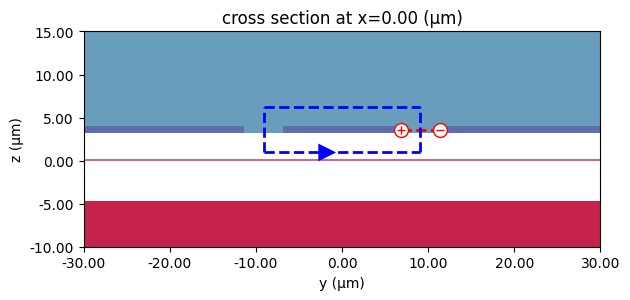

In [21]:
# Define a CPW port on the MET_1 layer (closer to the waveguide)
cpw_port = pf.cpw_spec(
    "MET_1",  # Layer for signal and ground lines
    signal_width,  # Width of the signal line (center conductor)
    gap_width,  # Gap between signal and ground lines
    ground_width,  # Width of ground planes
    description="CPW port",  # Description for visualization and metadata
    added_solver_modes=0,  # Number of extra solver modes (set to 0 for default)
    target_neff=2.2,  # Target effective index
    technology=tech,  # Reference to the custom technology stack
)

# Define a CPW port on the MET_2 (top metal) layer for routing above optical paths
top_cpw_port = pf.cpw_spec(
    "MET_2",  # Top metal layer
    signal_width,
    gap_width,
    ground_width,
    description="CPW port on top metal layer",
    added_solver_modes=0,
    target_neff=2.2,
    technology=tech,
)

# Create a Tidy3D impedance calculator to evaluate voltage/current path distributions
ic = top_cpw_port.to_tidy3d_impedance_calculator()

# Plot voltage and current integrals along the CPW cross-section
ax = pf.tidy3d_plot(top_cpw_port)
_ = ic.voltage_integral.plot(ax=ax, x=0)
_ = ic.current_integral.plot(ax=ax, x=0)

ax.set(xlim=(-30, 30), ylim=(-10, 15))

### CPW Via 

This function creates a **CPW via** component, defining the structures needed to connect CPW lines between two different metal layers (implicitly defined by `cpw_port` and `top_cpw_port`) using an intermediate via layer (`VIA`). We construct the geometry using path segments derived directly from the input CPW port specifications.

Here's how we build the component:
* We define the function to accept the `cpw_port` (for bottom metal and via dimensions) and `top_cpw_port` (for top metal dimensions) specifications directly, along with the via `length` and desired metal `extra_length`.
* **VIA Layer:** We get the path definitions (signal and grounds) from `cpw_port` and create segments of length `length` for each path on the `VIA` layer.
* **Bottom Metal Layer:** We again use `cpw_port` paths on the layers specified within `cpw_port` but start them offset horizontally by `-extra_length`. 
* **Top Metal Layer:** We use paths from `top_cpw_port` starting at `x=0`. We create segments extending to `x = length + extra_length`, resulting in top pads extending from `x = 0` to `x = length + extra_length` on the layers specified within `top_cpw_port`.
* **Ports:** Ports are automatically detected on the left boundary (using `cpw_port` specification) and right boundary (using `top_cpw_port` specification).

In [22]:
@pf.parametric_component()
def cpw_via(
    *,
    length=via_length,  # Length of the via cut itself (µm)
    extra_length=0,  # How much the metal pads extend beyond the via cut (µm)
    cpw_port=cpw_port,  # Port spec defining bottom metal/via dimensions & layers
    top_cpw_port=top_cpw_port,  # Port spec defining top metal dimensions & layers
):

    # Create a new component instance named "VIA"
    c = pf.Component("VIA")

    # Get path definitions (signal, grounds) from the bottom port spec, starting at origin
    cpw_paths_via = cpw_port.get_paths((0, 0))
    # Create via layer segments based on these paths
    for layer, path in cpw_paths_via:
        c.add("VIA", path.segment(endpoint=(length, 0)))  # Creates via cuts

    # Get path definitions from the bottom port spec, starting offset by -extra_length
    cpw_paths_bottom = cpw_port.get_paths((-extra_length, 0))
    # Create bottom metal layer segments
    for layer, path in cpw_paths_bottom:
        c.add(layer, path.segment(endpoint=(length, 0)))

    # Get path definitions from the top port spec, starting at origin
    cpw_paths_top = top_cpw_port.get_paths((0, 0))
    # Create top metal layer segments
    for layer, path in cpw_paths_top:
        c.add(layer, path.segment(endpoint=(length + extra_length, 0)))

    # Add and detect ports
    # Detect ports on the right boundary, using 'top_cpw_port' spec
    c.add_port(c.detect_ports([top_cpw_port], on_boundary="+x"))
    # Detect ports on the left boundary, using 'cpw_port' spec
    c.add_port(c.detect_ports([cpw_port], on_boundary="-x"))

    # Return the fully constructed via component
    return c


via = cpw_via(extra_length=30)
viewer.display(via)

### CPW Pad with Transition

This function creates a **CPW probe pad** component with an integrated transition (taper). It's designed to interface between large metallic pads suitable for electrical probing and a standard-width CPW transmission line.

The component features:
* Large contact pads (Signal, Ground, Ground) defined as [Terminals](../_autosummary/photonforge.Terminal.rst#photonforge.Terminal) on the top metal layer (`MET_2`).
* Via connections (`VIA` layer) and corresponding landing pads (`MET_1` layer) beneath the inner edge of the `MET_2` pads.
* A parametric transition (taper) on `MET_1` that smoothly changes the CPW dimensions from the pad connection width down to the standard CPW line width (`cpw_port` specification). The taper profile is exactly the same as what we used for the parametric S bend in the optical circuit.
* A single output port detected at the end of the CPW taper for connection to the rest of the circuit.

In [23]:
@pf.parametric_component()
def pad_cpw_transition(
    *,
    taper_length=taper_length,  # Length of the transition/taper section (µm)
    pad_width=pad_width,  # Width of each individual square pad (µm)
    pad_length=pad_length,  # Length of each individual square pad (µm)
    pad_gap=pad_gap,  # Gap between the signal and ground pads (µm)
    via_length=via_length,  # Length of the via connection under the pad (µm)
    cpw_port=cpw_port,  # Port spec defining bottom CPW
):
    # Create a new component instance named "PAD_CPW"
    c = pf.Component("PAD_CPW")

    # Define the large contact pads on MET_2 as Terminals (suitable for probing)
    # Ground pad 0 (bottom)
    c.add_terminal(
        pf.Terminal(
            "MET_2",  # Layer used when routing from this terminal
            pf.Rectangle(
                center=(pad_width / 2, -pad_width - pad_gap),
                size=(pad_width, pad_width),
            ),
        ),
        "G0",  # Terminal name
    )
    # Signal pad (center)
    c.add_terminal(
        pf.Terminal(
            "MET_2",  # Layer used when routing from this terminal
            pf.Rectangle(center=(pad_width / 2, 0), size=(pad_width, pad_width)),
        ),
        "S",  # Terminal name
    )
    # Ground pad 1 (top)
    c.add_terminal(
        pf.Terminal(
            "MET_2",  # Layer used when routing from this terminal
            pf.Rectangle(
                center=(pad_width / 2, pad_width + pad_gap),
                size=(pad_width, pad_width),
            ),
        ),
        "G1",  # Terminal name
    )

    # Add MET_2 pads
    c.add(
        "MET_2",
        # Signal landing pad on MET_1
        pf.Rectangle(
            center=(pad_length / 2, -pad_width - pad_gap),
            size=(pad_length, pad_width),
        ),
        # Top ground landing pad on MET_1
        pf.Rectangle(
            center=(pad_length / 2, 0),
            size=(pad_length, pad_width),
        ),
        # Bottom ground landing pad on MET_1
        pf.Rectangle(
            center=(pad_length / 2, pad_width + pad_gap),
            size=(pad_length, pad_width),
        ),
    )

    # Add MET_1 landing pads located under the inner edge of the MET_2 pads
    c.add(
        "MET_1",
        # Signal landing pad on MET_1
        pf.Rectangle(
            center=(pad_length - via_length / 2, 0), size=(via_length, pad_width)
        ),
        # Top ground landing pad on MET_1
        pf.Rectangle(
            center=(pad_length - via_length / 2, pad_width + pad_gap),
            size=(via_length, pad_width),
        ),
        # Bottom ground landing pad on MET_1
        pf.Rectangle(
            center=(pad_length - via_length / 2, -pad_width - pad_gap),
            size=(via_length, pad_width),
        ),
    )

    # Add VIA layer cuts connecting MET_1 landing pads to MET_2 pads
    # These vias have the same size and position as the MET_1 landing pads
    c.add(
        "VIA",
        # Signal via
        pf.Rectangle(
            center=(pad_length - via_length / 2, 0), size=(via_length, pad_width)
        ),
        # Top ground via
        pf.Rectangle(
            center=(pad_length - via_length / 2, pad_width + pad_gap),
            size=(via_length, pad_width),
        ),
        # Bottom ground via
        pf.Rectangle(
            center=(pad_length - via_length / 2, -pad_width - pad_gap),
            size=(via_length, pad_width),
        ),
    )

    # Define the CPW specification at the pad end (on MET_1, matching pad dimensions)
    cpw_pad_port = pf.cpw_spec(
        "MET_1", signal_width=pad_width, gap=pad_gap, ground_width=pad_width
    )

    # Create and add the transition (taper) component
    # This transitions from the pad dimensions (cpw_pad_port) to the standard line dimensions (cpw_port)
    transition = c.add_reference(
        pf.parametric.transition(
            port_spec1=cpw_pad_port,  # Starting port spec (pad end)
            port_spec2=cpw_port,  # Ending port spec (standard CPW line end)
            length=taper_length,  # Length over which the transition occurs
            profile="3*u^2-2*u^3",  # Smooth transition profile function
        )
    )
    # Position the start of the transition at the inner edge of the pads (x = pad_length)
    transition.translate((pad_length, 0))

    # Add the port at the CPW end of the transition.
    # The large pads were defined as Terminals, not Ports.
    c.add_port(transition["E1"])

    # Ensure exactly one port (the CPW output port) was detected.
    assert len(c.ports) == 1, "Port detection failed: expected exactly 1 port."

    return c


pad_cpw = pad_cpw_transition(taper_length=taper_length)
pad_cpw

## RF Circuit

**Creating Straight CPW Segments**

These lines instantiate specific straight Coplanar Waveguide segments, named `cpw2` and `cpw3`. Their lengths are calculated based on the dimensions of corresponding optical waveguide MZI arms.

To ensure these CPW segments fit correctly between connecting vias in the RF layout, the calculated lengths are adjusted by subtracting the appropriate via lengths (`via_length`).

Another CPW line (`cpw_on_met2`), created on the 'MET_2' layer, provides additional length to the RF path required for phase matching.

In [24]:
# Create an instance of a straight CPW with the calculated length, adjusting for two vias
cpw2 = pf.parametric.straight(
    port_spec=cpw_port, length=length_mzi_arm - 2 * via_length, name="CPW_2"
)

# Create an instance of a straight CPW with the calculated length, adjusting for one via
cpw3 = pf.parametric.straight(
    port_spec=cpw_port, length=length_mzi_arm - via_length, name="CPW_3"
)

# Create an instance of a straight CPW on 'MET_2' layer
cpw_on_met2 = pf.parametric.straight(port_spec=top_cpw_port, length=extra_cpw_path, name="CPW_MET_2")

**Adding and Positioning the Input Pad**

Here, we add an instance of the CPW probe pad component (`pad_cpw`) to the circuit, naming it `pad_in`. We then precisely position this input pad relative to components in the optical circuit:
* We align the vertical center (`y_mid`) of the pad with the vertical center of the input MMI (`mmi_in`).
* We align the right edge (`x_max`) of the pad with the left edge (`x_min`) of the top MZI arm waveguide (`wg_up_mzi_top`), placing the pad just before the start of the modulator's active region.

In [25]:
rf_circuit = pf.Component('RF_CIRCUIT')
# Add an instance of the CPW pad component to the circuit
pad_in = rf_circuit.add_reference(pad_cpw)
# Align the pad's vertical center with the input MMI's vertical center
pad_in.y_mid = mmi_in.y_mid
# Align the pad's right edge with the left edge of the top MZI waveguide arm
pad_in.x_max = wg_up_mzi_top.x_min

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Adding S-Bend Optical Routes (Input MMI to Top MZI)**

Previously, we skipped the optical routing between the input MMI and the first MZI section. Now, we add these connections using S-bend waveguides.

First, we calculate the required vertical `offset` for the S-bends. This calculation ensures the S-bends fit precisely within the geometric gap between the signal and ground lines of the RF taper connecting the input pad to the main CPW line. We then create a base S-bend component (`s_bend`) using a pre-defined `parametric_s_bend` function, setting its length equal to the RF `taper_length` and applying the calculated `offset`. The S-bend's curvature profile is designed to match the RF taper profile for a perfect fit.

We add two instances of this S-bend to the optical circuit: one directly (`s_bend_up_top`) and one mirrored vertically (`s_bend_down_top`). Finally, we connect the output ports (`P1`) of these S-bends to the respective input ports (`P0`) of the top MZI's upper and lower arm waveguides (`wg_up_mzi_top`, `wg_down_mzi_top`).

In [26]:
# Calculate the vertical offset needed for the S-bend to fit within the RF taper
offset = (pad_width + pad_gap - signal_width - gap_width) / 2
# Create a base S-bend component with the taper length and calculated offset
s_bend = parametric_s_bend(
    length=taper_length, offset=-offset
)  # Offset sign depends on coordinate system/port locations

# Add an instance for the upper path S-bend
s_bend_up_top = optical_circuit.add_reference(s_bend)
# Add a vertically mirrored instance for the lower path S-bend
s_bend_down_top = optical_circuit.add_reference(s_bend).mirror((1, 0))

# Connect the output of the upper S-bend to the input of the upper MZI arm
s_bend_up_top.connect("P1", wg_up_mzi_top["P0"])
# Connect the output of the lower S-bend to the input of the lower MZI arm
s_bend_down_top.connect("P1", wg_down_mzi_top["P0"])

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Routing Connections (Input MMI to S-Bends)**

Now that we have placed the S-bends, we need to connect the output ports of the input MMI (`mmi_in`) to the input ports of these S-bends. We use the parametric route function for this, which automatically generates an optimal waveguide path using the specified `bend_radius`.

We create two routes:
1.  `route_up_mzi_top`: Connects the upper output port (`P2`) of `mmi_in` to the input port (`P0`) of the upper S-bend (`s_bend_up_top`).
2.  `route_down_mzi_top`: Connects the lower output port (`P1`) of `mmi_in` to the input port (`P0`) of the lower S-bend (`s_bend_down_top`).

Finally, we add these generated route components as references to the circuit.

In [27]:
# Create the route from the MMI upper output (P2) to the upper S-bend input (P0)
route_up_mzi_top = pf.parametric.route(
    port1=(mmi_in, "P2"),  # Start port: mmi_in P2
    port2=(s_bend_up_top, "P0"),  # End port: s_bend_up_top P0
    radius=bend_radius,  # Bend radius for the route
)
# Add the generated upper route to the circuit
optical_circuit.add_reference(route_up_mzi_top)

# Create the route from the MMI lower output (P1) to the lower S-bend input (P0)
route_down_mzi_top = pf.parametric.route(
    port1=(mmi_in, "P1"),  # Start port: mmi_in P1
    port2=(s_bend_down_top, "P0"),  # End port: s_bend_down_top P0
    radius=bend_radius,  # Bend radius for the route
)
# Add the generated lower route to the circuit
optical_circuit.add_reference(route_down_mzi_top)

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Building the Top RF Path Segment**

Here, we begin constructing the main RF circuit path.
1.  We add the first straight CPW segment (`cpw_top`), which is an instance of `cpw3` (its length corresponds to the top MZI arm, adjusted for one via). We connect its input (`E0`) to the output (`E0`) of the input pad (`pad_in`).
2.  We create a standard via component (`via`) using our `cpw_via` function (with no extra metal overlap) and add it as `via_top`. We connect the via's bottom metal input (`E1`) to the output (`E1`) of the `cpw_top` segment.


In [28]:
# Add the first straight CPW segment (instance of cpw3)
cpw_top = rf_circuit.add_reference(cpw3)
# Connect the start of this CPW segment to the output of the input pad's taper
cpw_top.connect("E0", pad_in["E0"])

# Create a via instance with no extra metal extension
via = cpw_via(extra_length=0)
# Add the via instance to the circuit
via_top = rf_circuit.add_reference(via)
# Connect the via's bottom metal input (E1) to the end of the top CPW segment (E1)
via_top.connect("E1", cpw_top["E1"])

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Building the RF bend with an extra path**

For creating the bending part:
1.  We add an extra straight path (`cpw_on_met2_right_up`).
2.  We calculate a suitable radius (`cpw_bend_radius`) for the 180-degree CPW bends. This radius is based on the total vertical distance spanned by the folded optical path (the distance between input and output MMIs), ensuring the RF bends match the optical layout's extent.
3.  We create a [bent CPW component](../_autosummary/photonforge.parametric.bend.rst#photonforge.parametric.bend) (`cpw_bend`) using this calculated radius.
4.  We add an instance of this bend (`cpw_bend_right`) and connect its input (`E1`) to the top metal output (`E0`) of `via_top`. This completes the connection from the first straight segment, through the via, and into the first 180-degree RF bend.
5.  Finally, we add an additional extra straight path (`cpw_on_met2_right_down`)

In [29]:
# Add an extra straight path 
cpw_on_met2_right_up = rf_circuit.add_reference(cpw_on_met2)
cpw_on_met2_right_up.connect("E0", via_top["E0"])

# Calculate the required CPW bend radius based on optical path vertical span
cpw_bend_radius = (mmi_in.y_mid - mmi_out.y_mid) / 4
# Create a bent CPW component using the calculated radius
cpw_bend = pf.parametric.bend(port_spec=top_cpw_port, radius=cpw_bend_radius, angle=180)

# Add the first (right-side) 180-degree bend instance
cpw_bend_right = rf_circuit.add_reference(cpw_bend)
# Connect the bend's input (E1) to the via's top metal output (E0)
cpw_bend_right.connect("E1", cpw_on_met2_right_up["E1"])

# Add an extra straight path
cpw_on_met2_right_down = rf_circuit.add_reference(cpw_on_met2)
cpw_on_met2_right_down.connect("E0", cpw_bend_right["E0"])

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Adding the Middle RF Path Segment**

Continuing the RF circuit construction for the middle section:
1.  We add another via instance (`via_mid_right`). Its top metal input port ("E0") is connected to the output port ("E1") of the preceding extra path segment (`cpw_on_met2_right_down`). This transitions the RF path from the top metal (MET_2) down to the first metal layer (MET_1).
2.  Next, we add the middle straight CPW segment (`cpw_mid`), which is an instance of `cpw2` (length adjusted for two vias, on MET_1). Its input port (nominally "E1") is connected to the bottom metal output port ("E1") of `via_mid_right`.
3.  Finally, we add a third via instance (`via_mid_left`). Its bottom metal input port ("E1") is connected to the output port ("E0") of the `cpw_mid` segment. This prepares the path to transition back up to the top metal layer.

This completes the middle section of the main RF path, running on MET_1 between two vias. 

In [30]:
# Add the second via instance (after the first bend)
via_mid_right = rf_circuit.add_reference(via)
# Connect this via's top metal input (E0) to the first bend's output (E0)
via_mid_right.connect("E0", cpw_on_met2_right_down["E1"])

# Add the middle straight CPW segment (instance of cpw2)
cpw_mid = rf_circuit.add_reference(cpw2)
# Connect its input (E1) to the second via's bottom metal output (E1)
cpw_mid.connect("E1", via_mid_right["E1"])

# Add the third via instance (after the middle straight segment)
via_mid_left = rf_circuit.add_reference(via)
# Connect this via's bottom metal input (E1) to the middle CPW segment's output (E0)
via_mid_left.connect("E1", cpw_mid["E0"])

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Adding the Final RF Bend and Output Path**

Here, we complete the RF circuit path from the middle-left via to the output pad:
1.  We add the second 180-degree bend (`cpw_bend_left`) by referencing the `cpw_bend` component and mirroring it horizontally (`(0, 1)`) and two additional extra paths (`cpw_on_met2_left_up` and `cpw_on_met2_left_down`). .
2.  We add the fourth via instance (`via_bottom`).
3.  We add the final straight CPW segment (`cpw_bottom`), which is another instance of `cpw3`. 
4.  Finally, we add the output pad (`pad_out`), an instance of the `pad_cpw` component.


In [31]:
# Add an extra straight path
cpw_on_met2_left_up = rf_circuit.add_reference(cpw_on_met2)
cpw_on_met2_left_up.connect("E0", via_mid_left["E0"])

# Add the second 180-degree bend, mirrored horizontally relative to the first bend
cpw_bend_left = rf_circuit.add_reference(cpw_bend).mirror((0, 1))
# Connect this bend's input (E1) to the middle-left via's top metal output (E0)
cpw_bend_left.connect("E1", cpw_on_met2_left_up["E1"])

# Add an extra straight path
cpw_on_met2_left_down = rf_circuit.add_reference(cpw_on_met2)
cpw_on_met2_left_down.connect("E0", cpw_bend_left["E0"])

# Add the fourth via instance (after the second bend)
via_bottom = rf_circuit.add_reference(via)
# Connect this via's top metal input (E0) to the second bend's output (E0)
via_bottom.connect("E0", cpw_on_met2_left_down["E1"])

# Add the final straight CPW segment (instance of cpw3)
cpw_bottom = rf_circuit.add_reference(cpw3)
# Connect its input (E0) to the fourth via's bottom metal output (E1)
cpw_bottom.connect("E0", via_bottom["E1"])

# Add the output pad instance
pad_out = rf_circuit.add_reference(pad_cpw)
# Connect the pad's input taper (E0) to the final CPW segment's output (E1)
pad_out.connect("E0", cpw_bottom["E1"])

c = pf.Component().add(rf_circuit,optical_circuit)
viewer(c)

**Adding Final S-Bends, Routing, and Exporting GDS**

In these final steps for the optical circuit, we connect the outputs of the bottom MZI arms (`wg_up_mzi_bottom`, `wg_down_mzi_bottom`) to the input ports of the output MMI (`mmi_out`).
1.  We add two S-bend instances (`s_bend_up_bottom`, `s_bend_down_bottom`) based on the `s_bend` component defined earlier. Note that `s_bend_up_bottom` is mirrored vertically to align correctly.
2.  We connect the output ports (`P1`) of these S-bends to the corresponding output ports (`P1`) of the bottom MZI arms.
3.  We use `pf.parametric.route` again to automatically generate the waveguide routes connecting the input ports (`P2`, `P1`) of the output MMI (`mmi_out`) to the input ports (`P0`) of the respective S-bends (`s_bend_up_bottom`, `s_bend_down_bottom`), using the standard `bend_radius`. We add these routes to the circuit.
4.  Finally, after completing all connections, we prepare the `optical_circuit` object by adding a model and ports.

In [32]:
# Add the S-bend for the upper path, mirrored vertically
s_bend_up_bottom = optical_circuit.add_reference(s_bend).mirror((1, 0))
# Add the S-bend for the lower path (no mirror needed)
s_bend_down_bottom = optical_circuit.add_reference(s_bend)

# Connect the upper S-bend output (P1) to the upper MZI arm output (P1)
s_bend_up_bottom.connect("P1", wg_up_mzi_bottom["P1"])
# Connect the lower S-bend output (P1) to the lower MZI arm output (P1)
s_bend_down_bottom.connect("P1", wg_down_mzi_bottom["P1"])

# Create the route from the output MMI upper input (P2) to the upper S-bend input (P0)
route_up_mzi_bottom = pf.parametric.route(
    port1=(mmi_out, "P2"),  # Start port: mmi_out P2
    port2=(s_bend_up_bottom, "P0"),  # End port: s_bend_up_bottom P0
    radius=bend_radius,  # Bend radius for the route
)
# Add the generated upper route to the circuit
optical_circuit.add_reference(route_up_mzi_bottom)

# Create the route from the output MMI lower input (P1) to the lower S-bend input (P0)
route_down_mzi_bottom = pf.parametric.route(
    port1=(mmi_out, "P1"),  # Start port: mmi_out P1
    port2=(s_bend_down_bottom, "P0"),  # End port: s_bend_down_bottom P0
    radius=bend_radius,  # Bend radius for the route
)
# Add the generated lower route to the circuit
optical_circuit.add_reference(route_down_mzi_bottom)

# Add circuit model to the optical circuit
optical_circuit.add_model(pf.CircuitModel())

# Automatically detect and define the two SWG250 ports
optical_circuit.add_port(optical_circuit.detect_ports(["SWG250"]))
assert len(optical_circuit.ports) == 2, "Port detection failed: expected exactly 2 ports."


Finally, the complete `optical_circuit` and `rf_circuit` components are combined by adding them as references into a single top-level `circuit` component. This final, integrated layout is then exported to a GDSII file named `FOLDED-MODULATOR.gds`.

In [33]:
circuit = pf.Component("CIRCUIT")
circuit.add_reference(optical_circuit)
circuit.add_reference(rf_circuit)

# Write the complete circuit layout to a GDSII file
circuit.write_gds("FOLDED-MODULATOR.gds")

Besides generating the GDSII layout for fabrication, we can also store the full design in a phf file to keep track of the technology specifications, ports and models in the design, not only its geometry.

In [34]:
pf.write_phf("FOLDED-MODULATOR.phf")